In [1]:
# Use this to analyze extracted data!
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# For Data parsing
import os
import re

target_runs = 674

In [2]:
# save all data in numpy arrays
directory = "/Users/kianavillaera/MMDA_Traffic_data/EDSA-Traffic-Analysis-and-Visualization/April29_to_May6"
j = 0 # file number 

list_of_southbound = np.zeros(24938).reshape(37,674) 
list_of_northbound = np.zeros(24938).reshape(37,674)

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        f = open(filename)
        f_list = f.readlines()
        i = 0
        for row in f_list:
            if len(row) == 41:
                vol = re.findall("\d",row)
                list_of_southbound[i][j] = vol[0]
                list_of_northbound[i][j] = vol[1]
                i += 1       
        j +=1        
        f.close()        

In [3]:
# Function for data analysis

def analyze(data, target_runs, bound):
    %matplotlib inline 
    x = range(0,target_runs)
    x = np.array(x)
    data = np.array(data)
    
    p1 = np.polyfit(x,data,1) #order 1
    p2 = np.polyfit(x,data,2) #order 2
    p3 = np.polyfit(x,data,3) #order 3
    plt.style.use('seaborn-whitegrid')
    
    #plot data and linear fit
    plt.plot(x,data,'o')
    plt.plot(x,np.polyval(p1,x),'r-')
    plt.plot(x,np.polyval(p2,x),'g--')
    plt.plot(x,np.polyval(p3,x),'y:') 
    plt.savefig("Polynomial regression of "+ bound +" traffic data.png")
    plt.show()
    
    plt.xlabel("Road")
    plt.ylabel("Volume")
    
   # print("Slope and intercepts in ascending orders ")
    print(p1)
    print(p2)
    print(p3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


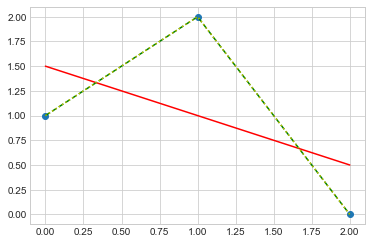

[-0.5  1.5]
[-1.5  2.5  1. ]
[-0.42647059 -0.22058824  1.64705882  1.        ]


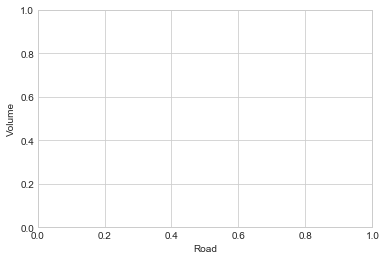

In [7]:
# Loop through both arrays
data = list_of_southbound[22]
analyze(data, target_runs, "South")